# Stage One 

I first set up my Twitter API, and then imported tweepy. Once I had my public tweets availble to me to work with, I imported PANDAS so that I could pull up and parse tweets with the hastag, "#theeternals." I pulled tweets since 10/17/21 to get the most recent tweets since the movie previewed to critics. 

In [7]:
import configparser
import tweepy

CONFIG = configparser.ConfigParser()
CONFIG.read('credentials.ini')

auth = tweepy.OAuthHandler(CONFIG['DEFAULT']['consumer_key'], CONFIG['DEFAULT']['consumer_secret'])
auth.set_access_token(CONFIG['DEFAULT']['access_token'], CONFIG['DEFAULT']['access_token_secret'])

api = tweepy.API(auth, wait_on_rate_limit=True)

public_tweets = api.home_timeline()
for tweet in public_tweets:
    print(tweet.text)

Five mayoral races to watch on Tuesday https://t.co/acHXsF5LXq
Meeting with Pope Francis leaves a strong impression on President Biden: He "is everything I learned about Catholic… https://t.co/7xPRpKMeaJ
RT @lychee_fan: One of my mentors, M.D. Coverley (Margie Luesebrink) will be talking about her work this Friday!
Imagining a world where Earth is destroyed by climate change and all traces of civilization disappear except this v… https://t.co/inDyBTSr45
This is what happens when an entire TV network is devoted to dripping poison into people's ears. https://t.co/xrNrt1X9ai
Progressives signal they'll back both economic bills ahead of likely vote later this week https://t.co/BQ7tMEBvkv
From investments in clean energy and manufacturing, electric vehicles, coastal restoration, forest management, and… https://t.co/ulj1tNdcb2
Sneak peek at Tucker Carlson’s Jan. 6 documentary (warning: spoilers) https://t.co/dGdqVnAaJu
They understood the 🎃  assignment. 📸 https://t.co/QUWUPAbPv9
Republican v

In [8]:
import pandas as pd

search_words = "#theeternals"
date_since = "2021-10-17"
tweets = tweepy.Cursor(api.search_tweets,
              q=search_words, lang="en").items(300)

tweets_sorted = [[tweet.user.screen_name, tweet.geo, tweet.user.location, tweet.text] for tweet in tweets]

# Stage Two 

After importing Pandas, I used it to sort and analyze my tweets. I focused on the data points I was most interested in, the username, coordinates, location and the tweet itself, and created a new dataframe. 

In [9]:
tdf = pd.DataFrame(data=tweets_sorted, columns=['user', 'coordinates','location', 'tweet'])
print(tdf)

              user coordinates                 location  \
0        mostavers        None           Athens, Greece   
1     MissJessicaO        None                  Nowhere   
2      1_DemiGod_1        None  Cape Town, South Africa   
3    WTW_StAustell        None    St. Austell, Cornwall   
4       THEdotBest        None          Los Angeles, CA   
..             ...         ...                      ...   
295      ReignSkol        None                            
296   urban_stores        None           Lagos, Nigeria   
297    pcol_verona        None            verona, italy   
298         blogTO        None                  Toronto   
299        donje__        None   Laugh Tale, Grand Line   

                                                 tweet  
0    #TheEternals has dropped again, it looks so….r...  
1                           #TheEternals this Friday 😁  
2    I have a feeling MarvelStudios' #TheEternals i...  
3    The latest Marvel movie #TheEternals opens in ...  
4    W

# Stage Three 

I printed a sample set of user locations. I then imported geopy and used it to calculate user coordinates, where feasible, for my set of collected tweets. 

In [10]:
locs = tdf['location'].value_counts()
print(locs)

                                  83
somewhere being ya momma’s fav    10
Yongin, South Korea                9
New York, NY                       7
United States                      7
                                  ..
Laugh Tale, Grand Line             1
Phantom Zone...Alpha Centauri      1
Louisiana                          1
Birmingham, england                1
Los Angeles                        1
Name: location, Length: 154, dtype: int64


In [11]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent='twitter-analysis-client')
limited = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def find_location(row):
    place = row['location']
    location = limited(place)
    
    if location != None:
        return location.latitude, location.longitude
    else:
        return "Not Found", "Not Found"

tdf[['latitude','longitude']] = tdf.apply(find_location, axis="columns", result_type="expand")
tdf

,user,coordinates,location,tweet,latitude,longitude
0,mostavers,None,"Athens, Greece","#TheEternals has dropped again, it looks so….r...",37.983941,23.728305
1,MissJessicaO,None,Nowhere,#TheEternals this Friday 😁,38.731112,-95.24141
2,1_DemiGod_1,None,"Cape Town, South Africa",I have a feeling MarvelStudios' #TheEternals i...,-33.928992,18.417396
3,WTW_StAustell,None,"St. Austell, Cornwall",The latest Marvel movie #TheEternals opens in ...,50.342397,-4.774209
4,THEdotBest,None,"Los Angeles, CA",What's #Best today on https://t.co/G6lwXK6a0w ...,34.053691,-118.242766
...,...,...,...,...,...,...
295,ReignSkol,None,,RT @CinemaTweets1: Angelina Jolie is an Oscar ...,Not Found,Not Found
296,urban_stores,None,"Lagos, Nigeria",Copy designer perfume \n100 ml awesome fragran...,6.455057,3.394179
297,pcol_verona,None,"verona, italy",RT @misanharriman: I’ve been lucky enough to s...,45.438496,10.992412
298,blogTO,None,Toronto,Catch @TheEternals at the Cinesphere next mont...,43.653482,-79.383935


# Stage Four 

I then used matplot lib and cartopy to map the tweets using the calculated locations.

In [12]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (20, 10)

/Users/Rachel/opt/anaconda3/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


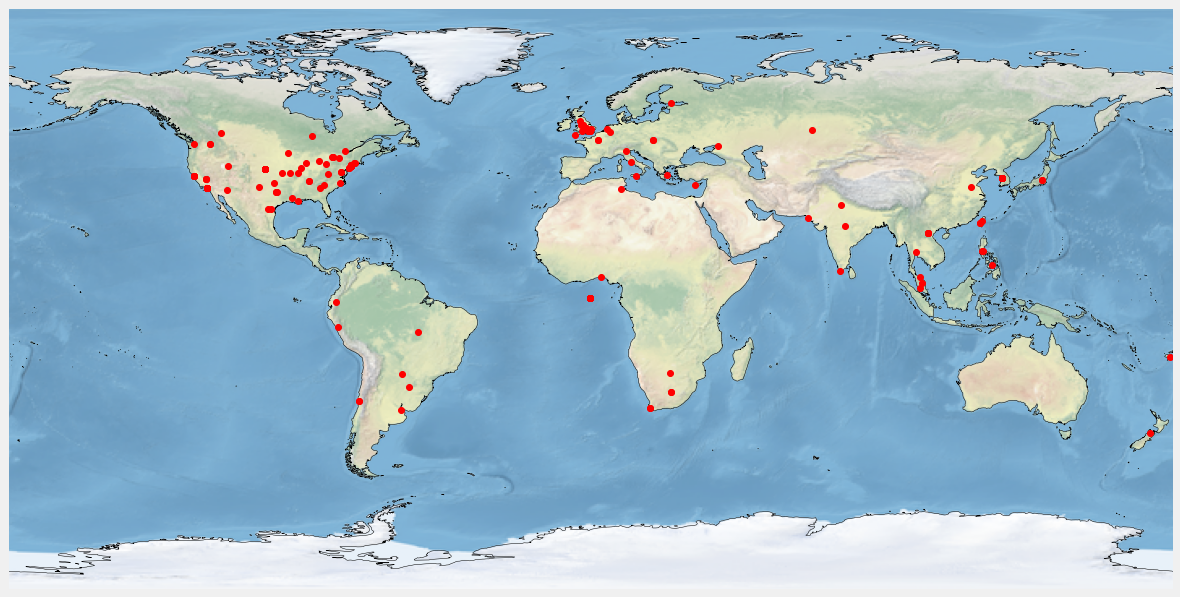

In [13]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle

lats = tdf['latitude'].dropna()
longs = tdf['longitude'].dropna()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
    
for i in range(0, len(lats)):
    ax.plot(longs[i], lats[i], 'ro', transform=ccrs.PlateCarree())
                                                                                              
ax.coastlines(resolution='50m')
ax.set_global()

plt.show()

# Stage Five 

Lastly, I found the value counts for the top hashtags used in the dataset (by finding text from the tweets that starting with a pound sign) and visualized it using a bar graph. 

<AxesSubplot:title={'center':'Top Hashtags'}>

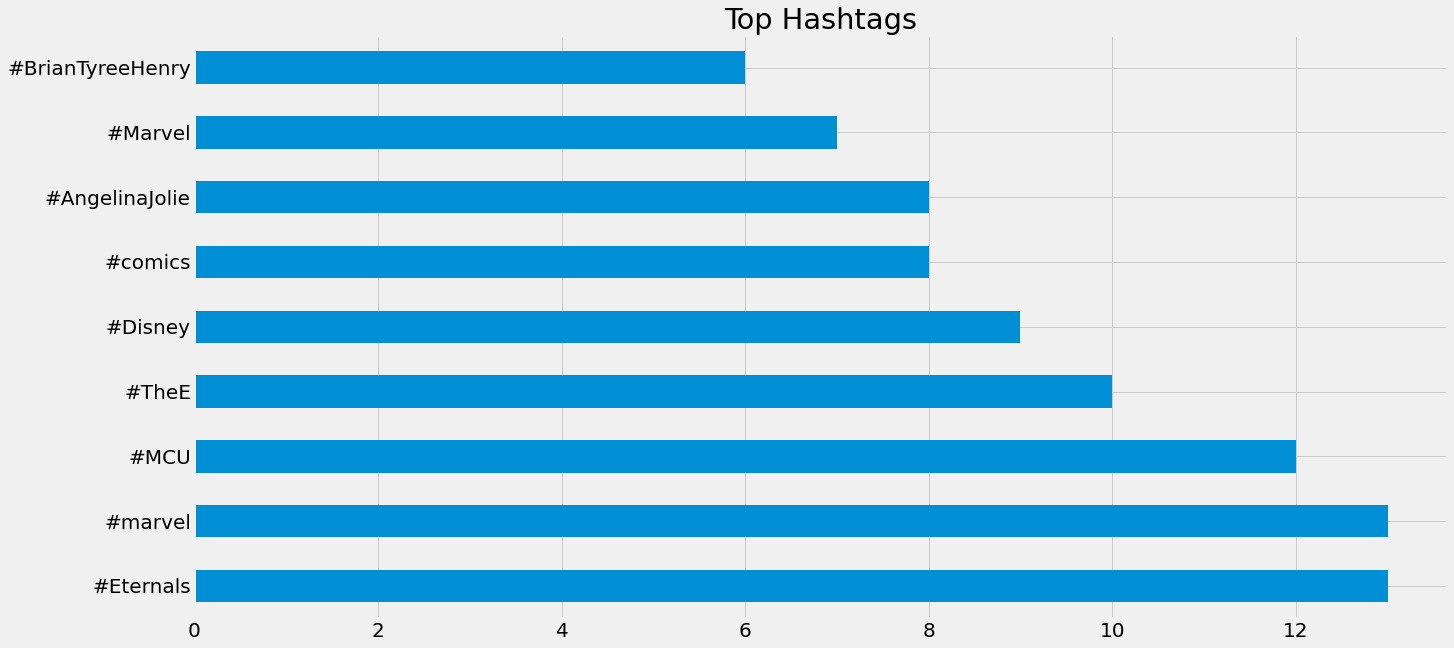

In [20]:
hashtags = tdf['tweet'].str.extractall(r'(\#\w+)')[0].value_counts()

hashtags[1:10].plot(kind='barh', title='Top Hashtags')